In [5]:
import os
import cv2

In [6]:
import matplotlib.pyplot as plt
from droplet_corr_lab.common import save_json, load_json, load_csv
from droplet_corr_lab.preprocessing import image_preprocessing

In [7]:
pos_ref_ID = 0
bri_ref_ID = 100

In [8]:
print(os.getcwd())

D:\python_files\PhD_work\examples


In [9]:
image_dir_ ="../data/demo/raw_images"
frame_IDs_all = [10*i for i in range(11)]
pos_ref = os.path.join(image_dir_, f"{pos_ref_ID}.jpg")
bri_ref = os.path.join(image_dir_, f"{bri_ref_ID}.jpg")
pos_ref_rgb = cv2.cvtColor(cv2.imread(pos_ref), cv2.COLOR_BGR2RGB)
bri_ref_rgb = cv2.cvtColor(cv2.imread(bri_ref), cv2.COLOR_BGR2RGB)

In [10]:
mask_ID = 0
mask_path_ = f"../data/demo/masked/{mask_ID}"

## Image segmentation with SAM (Compute binary mask)

In [ ]:
from droplet_corr_lab.segmentation import SAMMaskGenerator
from droplet_corr_lab.preprocessing import crop_image_to_patches

In [ ]:
num_patches_width=6 # col
num_patches_height=6 # row

In [ ]:
mask_image_path = os.path.join(image_dir_, f"{mask_ID}.jpg")
mask_image = image_preprocessing(cv2.cvtColor(cv2.imread(pos_ref), cv2.COLOR_BGR2RGB), pos_ref_rgb, bri_ref_rgb)
crop_path = f"../data/demo/cropped/{mask_ID}"
patches_all = crop_image_to_patches(image_ori=mask_image,
                                           mask_ID=mask_ID,
                                           num_patches_width=num_patches_width,
                                           num_patches_height=num_patches_height,
                                           crop_path=crop_path,
                                           save_patches=True)

In [ ]:
sam_obj = SAMMaskGenerator(
    checkpoint_path="",
    model_type="vit_h",
    points_per_side=70,
    pred_iou_thresh=0.75,
    stability_score_thresh=0.75
)

In [ ]:
# 50s processing time for one image at approx. 200*250 on nvidia 4060 laptop GPU 
primary_results = sam_obj.segment_primary(
    patches_rgb=[patches_all[4], patches_all[9], patches_all[21]],      # list of ((r,c), rgb)
    num_rows=num_patches_height,
    num_cols=num_patches_width,
    save_dir=mask_path_,
    mask_ID=mask_ID
)

In [ ]:
refined_results = sam_obj.segment_refined(primary_results=primary_results,
                        num_rows=num_patches_height,
                        num_cols=num_patches_width,
                        processes=4,
                        max_area_ratio=0.2,
                        aspect_threshold=10.0,
                        min_solidity=1.0,
                        overlap_threshold=0.5,
                        neighbor_size_range=(0.2, 0.8),
                        safe_size_threshold=0.1,
                        max_overlap_count=2
                        )

In [ ]:
sam_obj.save_binary_masks(patches=refined_results, save_dir=mask_path_, mask_ID=mask_ID)

## Analyze binary mask

In [11]:
from droplet_corr_lab.segmentation import concat_mask, detect_droplet_regions, compute_inner_outer_roi_all_droplets

In [12]:
roi_outer_frac=0.4
edge_thresh=5

177 dict_keys(['bbox', 'area', 'perimeter', 'aspect_ratio', 'centroid', 'coords'])


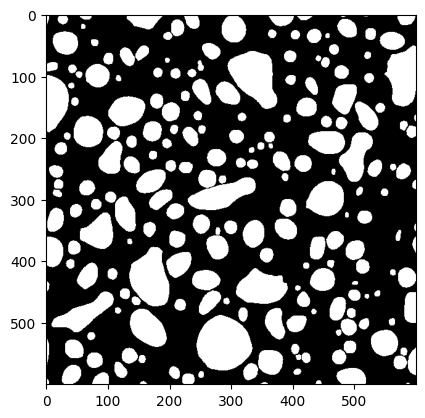

In [13]:
# adjust to modification based on how mask is saved
binary_mask = concat_mask(mask_path_)
plt.imshow(binary_mask, cmap='gray')
droplets = detect_droplet_regions(binary_mask, min_area=5, edge_thresh=edge_thresh)
print(len(droplets), droplets[0].keys())

In [14]:
mask_coords_inner, mask_coords_outer, geo = compute_inner_outer_roi_all_droplets(
    droplets=droplets,
    image_shape=binary_mask.shape,
    roi_outer_frac=roi_outer_frac,
    binary_mask=binary_mask
)
save_json(mask_coords_inner, f"../data/demo/coords/{mask_ID}_inner.json")
save_json(mask_coords_outer, f"../data/demo/coords/{mask_ID}_outer_{roi_outer_frac}.json")
save_json(geo, f"../data/demo/coords/{mask_ID}_geo.json")

## Compute raw features

In [15]:
mask_coords_inner = load_json(f"../data/demo/coords/{mask_ID}_inner.json")
mask_coords_outer = load_json(f"../data/demo/coords/{mask_ID}_outer_{roi_outer_frac}.json")
geos_all = load_json(f"../data/demo/coords/{mask_ID}_geo.json")

### Statistical

In [16]:
raw_f_dir = f"../data/demo/raw_roi_{roi_outer_frac}"

In [17]:
from droplet_corr_lab.features.statistical import build_features

In [18]:
image_rgb_raw_all = [cv2.cvtColor(cv2.imread(os.path.join(image_dir_, f"{source_ID}.jpg")), cv2.COLOR_BGR2RGB) for source_ID in frame_IDs_all]

In [19]:
print(os.cpu_count())

16


In [20]:
# suggested: n_workers = os.cpu_count()//2
build_features(
    image_rgb_raw_all=image_rgb_raw_all,
    image_pos_ref=pos_ref_rgb,
    image_bri_ref=bri_ref_rgb,
    frame_idx_all=frame_IDs_all,
    mask_coords_inner=mask_coords_inner,
    mask_coords_outer=mask_coords_outer,
    method='ring',
    inner_descriptors=['rgb_m_s'],
    outer_descriptors=['rgb_m_s', 'gradient'],
    geos_all=geos_all,
    target_size= (32, 32),
    param_inner=5,
    param_outer=2,
    edge_thresh_mask=edge_thresh,
    save_features=True,
    saving_par_dir=raw_f_dir,
    n_workers=8
)

### AutoEncoder

In [21]:
# For consistency (not mandatory), keep latent_dim for inner and outer same as feature size generated by statistical method

In [22]:
from droplet_corr_lab.features.learned import AEFeaturePipeline
ae_obj = AEFeaturePipeline(
    latent_dim_inner=30,
    latent_dim_outer=26,
    num_epochs=200
)

PyTorch version: 2.5.0+cu124
CUDA is available: True
Number of GPUs available: 1
NVIDIA GeForce RTX 4060 Laptop GPU


In [23]:
raw_ae_f_dir = f"../data/demo/raw_ae_roi_{roi_outer_frac}"

In [24]:
ae_obj.build_features(
    image_rgb_raw_all=image_rgb_raw_all,
   frame_idx_all=frame_IDs_all,
   image_pos_ref=pos_ref_rgb,
   image_bri_ref=bri_ref_rgb,
   mask_coords_inner=mask_coords_inner,
   mask_coords_outer=mask_coords_outer,
   geos_all=geos_all,
   save_dir=raw_ae_f_dir

)

Training AE for INNER ROIs...
Epoch [10/200] | Train Loss: 0.004985 | Val Loss: 0.004782 | LR: 1.00e-04
Epoch [20/200] | Train Loss: 0.002670 | Val Loss: 0.002626 | LR: 1.00e-04
Epoch [30/200] | Train Loss: 0.002057 | Val Loss: 0.002027 | LR: 1.00e-04
Epoch [40/200] | Train Loss: 0.001659 | Val Loss: 0.001651 | LR: 1.00e-04
Epoch [50/200] | Train Loss: 0.001463 | Val Loss: 0.001462 | LR: 1.00e-04
Epoch [60/200] | Train Loss: 0.001345 | Val Loss: 0.001342 | LR: 1.00e-04
Epoch [70/200] | Train Loss: 0.001245 | Val Loss: 0.001232 | LR: 1.00e-04
Epoch [80/200] | Train Loss: 0.001155 | Val Loss: 0.001147 | LR: 1.00e-04
Epoch [90/200] | Train Loss: 0.001073 | Val Loss: 0.001061 | LR: 1.00e-04
Epoch [100/200] | Train Loss: 0.001006 | Val Loss: 0.001000 | LR: 1.00e-04
Epoch [110/200] | Train Loss: 0.000959 | Val Loss: 0.000956 | LR: 1.00e-04
Epoch [120/200] | Train Loss: 0.000916 | Val Loss: 0.000912 | LR: 1.00e-04
Epoch [130/200] | Train Loss: 0.000885 | Val Loss: 0.000880 | LR: 1.00e-04
Epoc

D:\python_files\PhD_work\droplet_corr_lab\features\learned\training\train_conv_ae.py:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(mode

Epoch [10/200] | Train Loss: 0.004965 | Val Loss: 0.004720 | LR: 1.00e-04
Epoch [20/200] | Train Loss: 0.002846 | Val Loss: 0.002787 | LR: 1.00e-04
Epoch [30/200] | Train Loss: 0.002160 | Val Loss: 0.002128 | LR: 1.00e-04
Epoch [40/200] | Train Loss: 0.001744 | Val Loss: 0.001730 | LR: 1.00e-04
Epoch [50/200] | Train Loss: 0.001517 | Val Loss: 0.001501 | LR: 1.00e-04
Epoch [60/200] | Train Loss: 0.001382 | Val Loss: 0.001371 | LR: 1.00e-04
Epoch [70/200] | Train Loss: 0.001276 | Val Loss: 0.001269 | LR: 1.00e-04
Epoch [80/200] | Train Loss: 0.001203 | Val Loss: 0.001192 | LR: 1.00e-04
Epoch [90/200] | Train Loss: 0.001133 | Val Loss: 0.001130 | LR: 1.00e-04
Epoch [100/200] | Train Loss: 0.001077 | Val Loss: 0.001071 | LR: 1.00e-04
Epoch [110/200] | Train Loss: 0.001024 | Val Loss: 0.001014 | LR: 1.00e-04
Epoch [120/200] | Train Loss: 0.000979 | Val Loss: 0.000969 | LR: 1.00e-04
Epoch [130/200] | Train Loss: 0.000944 | Val Loss: 0.000936 | LR: 1.00e-04
Epoch [140/200] | Train Loss: 0.00

## Compute PCA

In [30]:
# Choose which set of raw feature files to continue
r_dir = raw_f_dir

In [31]:
from droplet_corr_lab.compute import pca_visualization_on_combined_dataset, pca_on_combined_dataset, combine_raw_features_across_frames

In [32]:
data_args = combine_raw_features_across_frames(
    raw_features_dir=r_dir,
    frame_IDs_all=frame_IDs_all
)

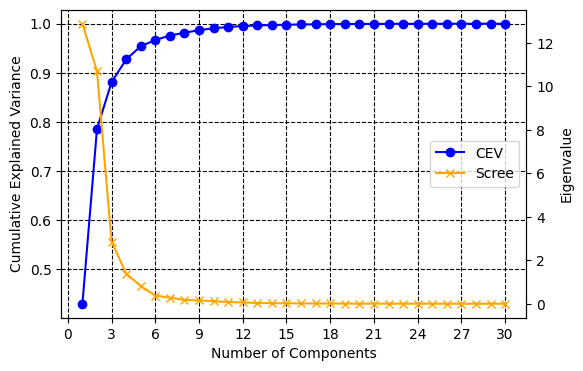

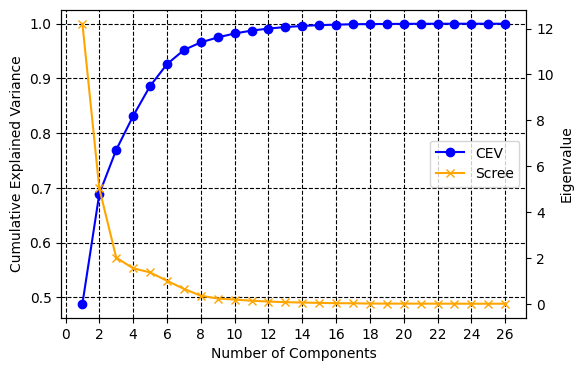

In [33]:
pca_visualization_on_combined_dataset(data_args,
                                      roi_key='inner',
                                      scaling_method='standard')
pca_visualization_on_combined_dataset(data_args,
                                      roi_key='outer',
                                      scaling_method='standard')

In [34]:
num_pc_inner=4
num_pc_outer=6

In [35]:
_, (norm_w_inner, norm_w_outer) = pca_on_combined_dataset(
                                    data_args=data_args,
                                    raw_features_dir=r_dir,
                                    num_pc_inner=num_pc_inner,
                                    num_pc_outer=num_pc_outer,
                                    scaling_method='standard',
                                    only_compute_weights=False,
                                    save_df=True,
                                    roi_frac=roi_outer_frac
                                )

## Clustering

In [36]:
from droplet_corr_lab.compute import primary_clustering, update_clustering, refine_centers

In [37]:
pc_df = load_csv(f"../data/demo/pc_df_roi_{roi_outer_frac}/inner_{num_pc_inner}_outer_{num_pc_outer}.csv")

### Inner

(174,)
[KMeans(n_clusters=2, random_state=42), 'kmeans++', array([[0.79340513, 0.35209091, 0.54012771, 0.51734085],
       [0.17728547, 0.40597763, 0.46589356, 0.54856981]]), MinMaxScaler(), 'minmax']


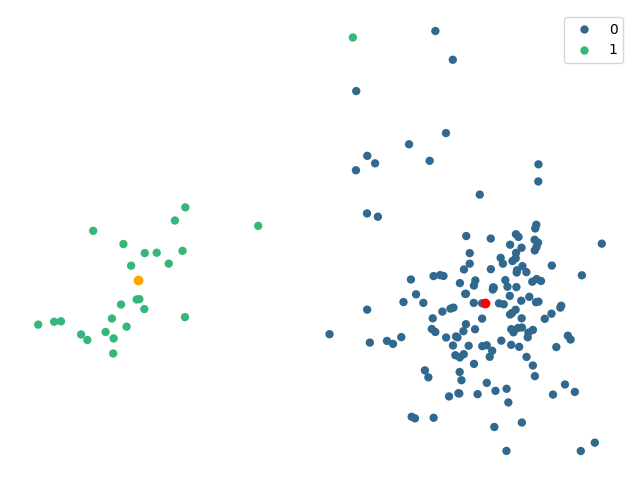

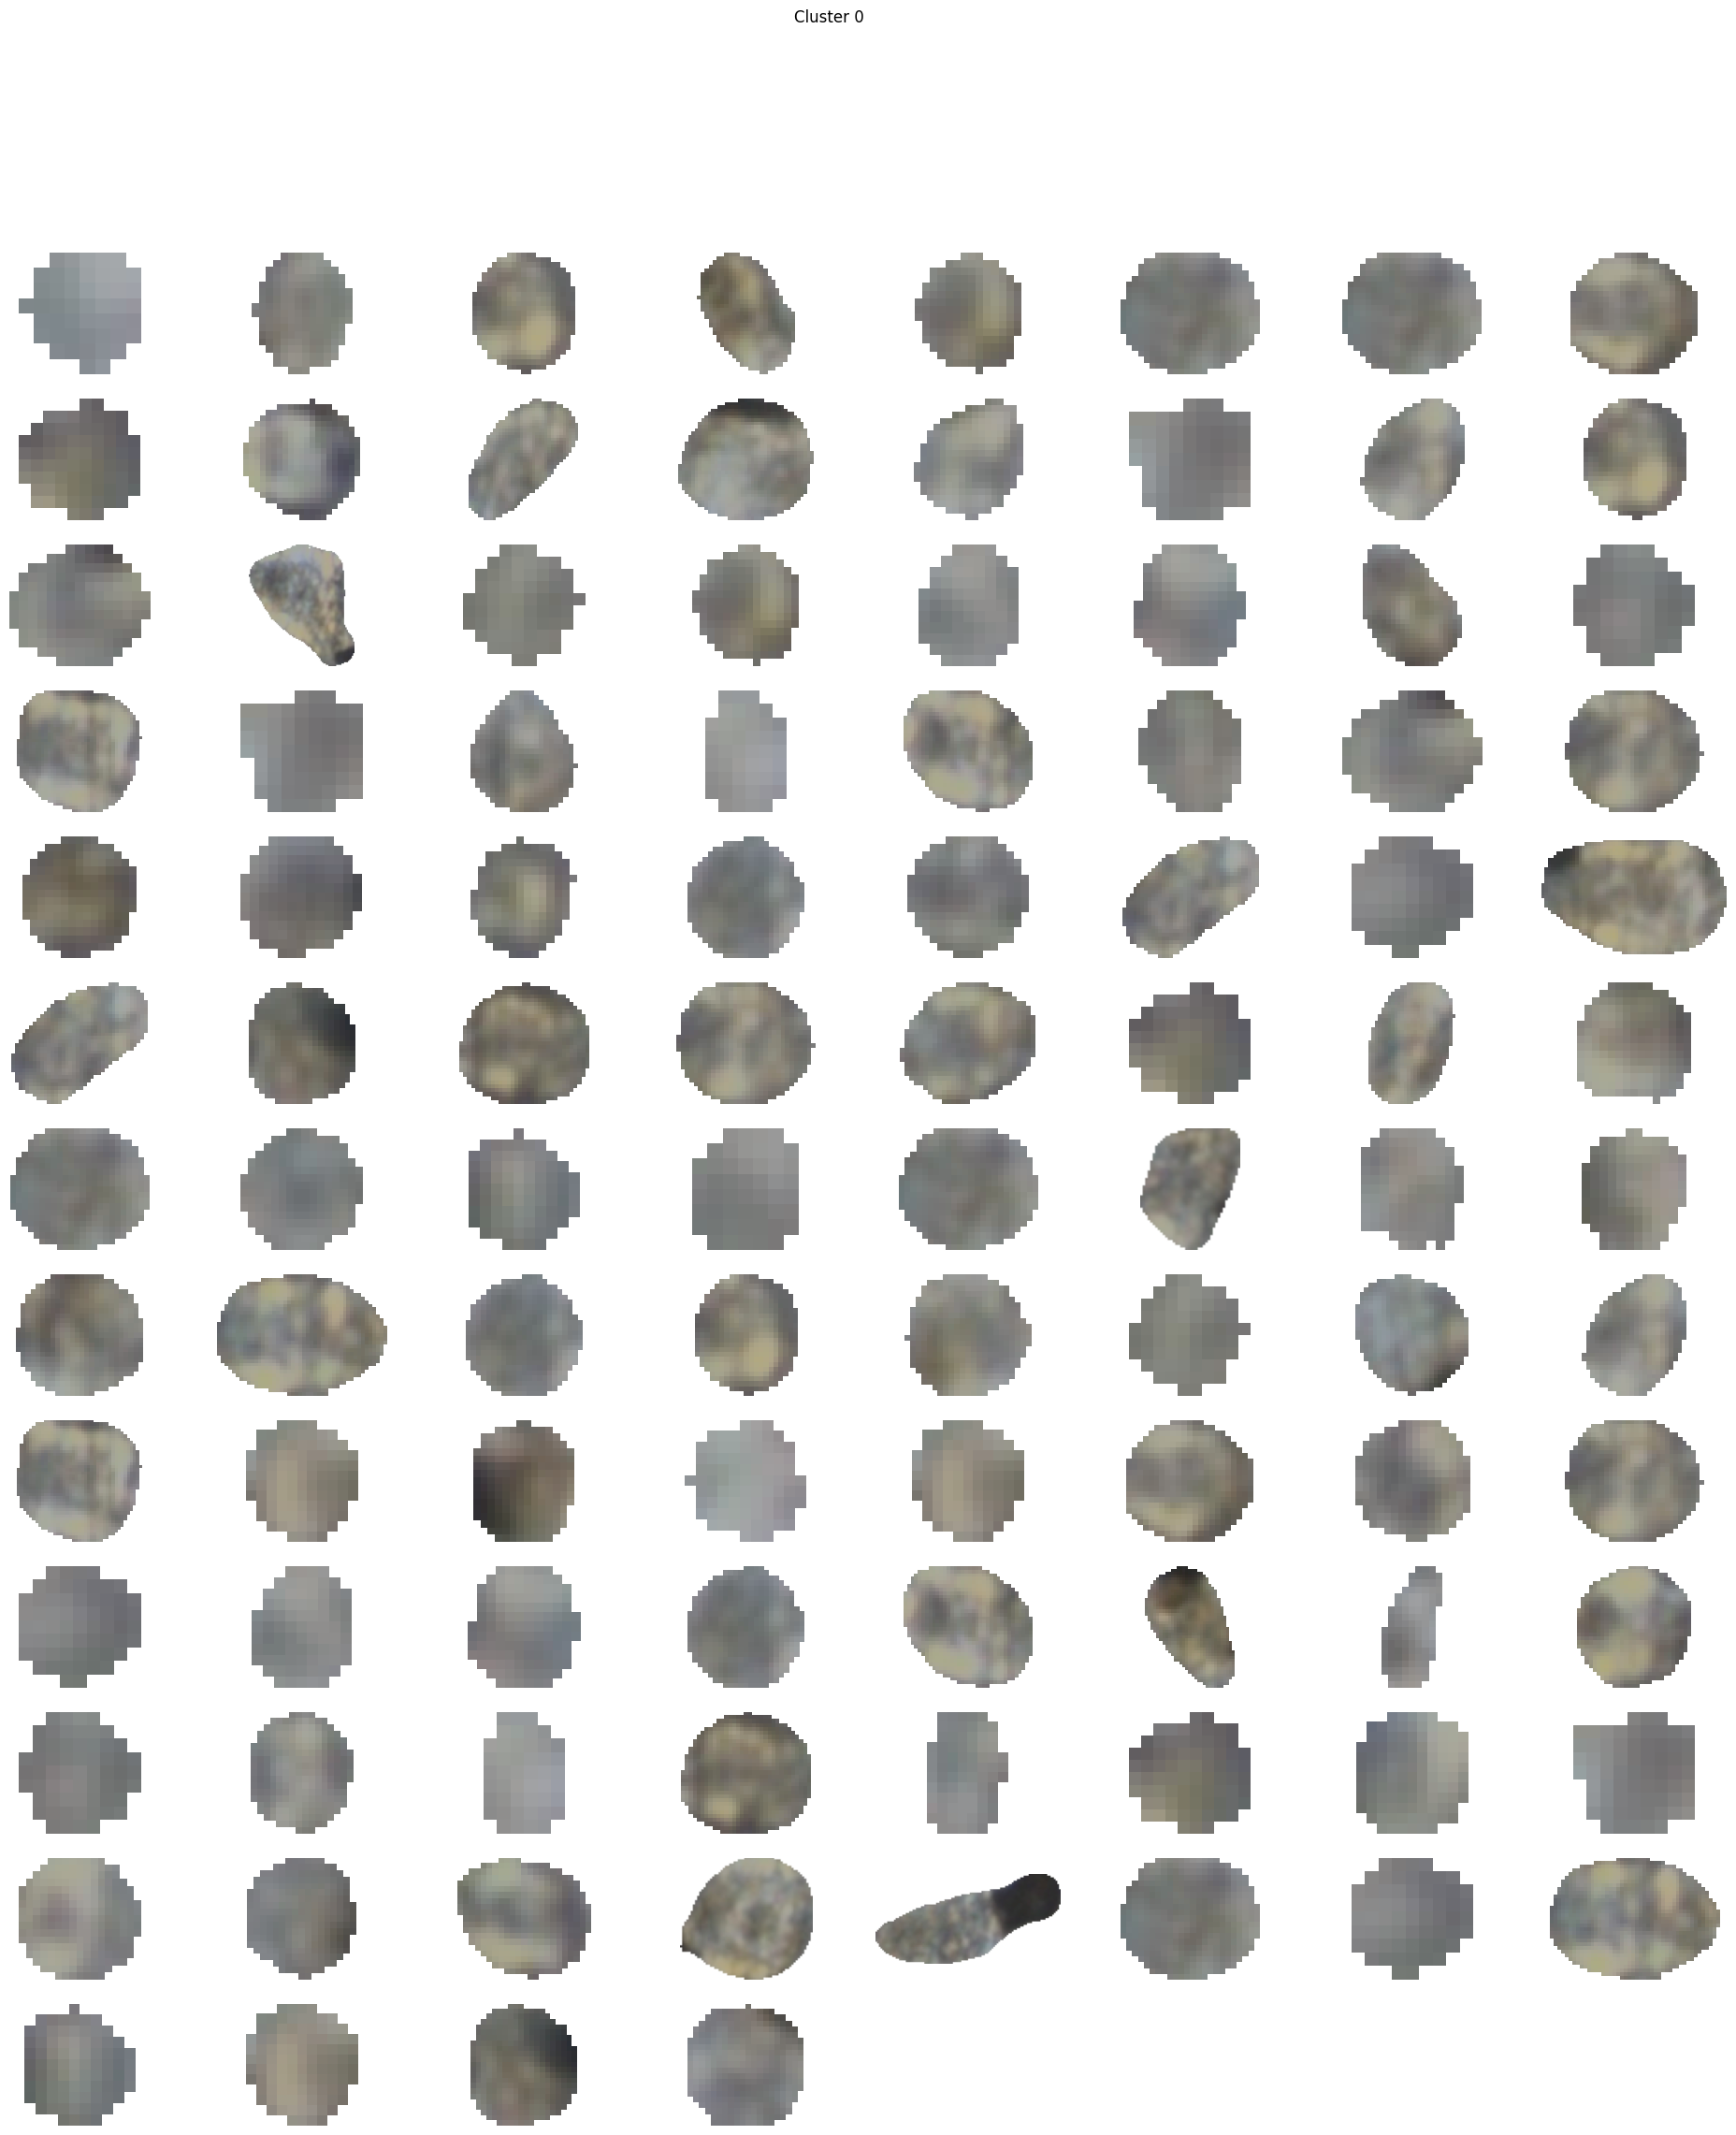

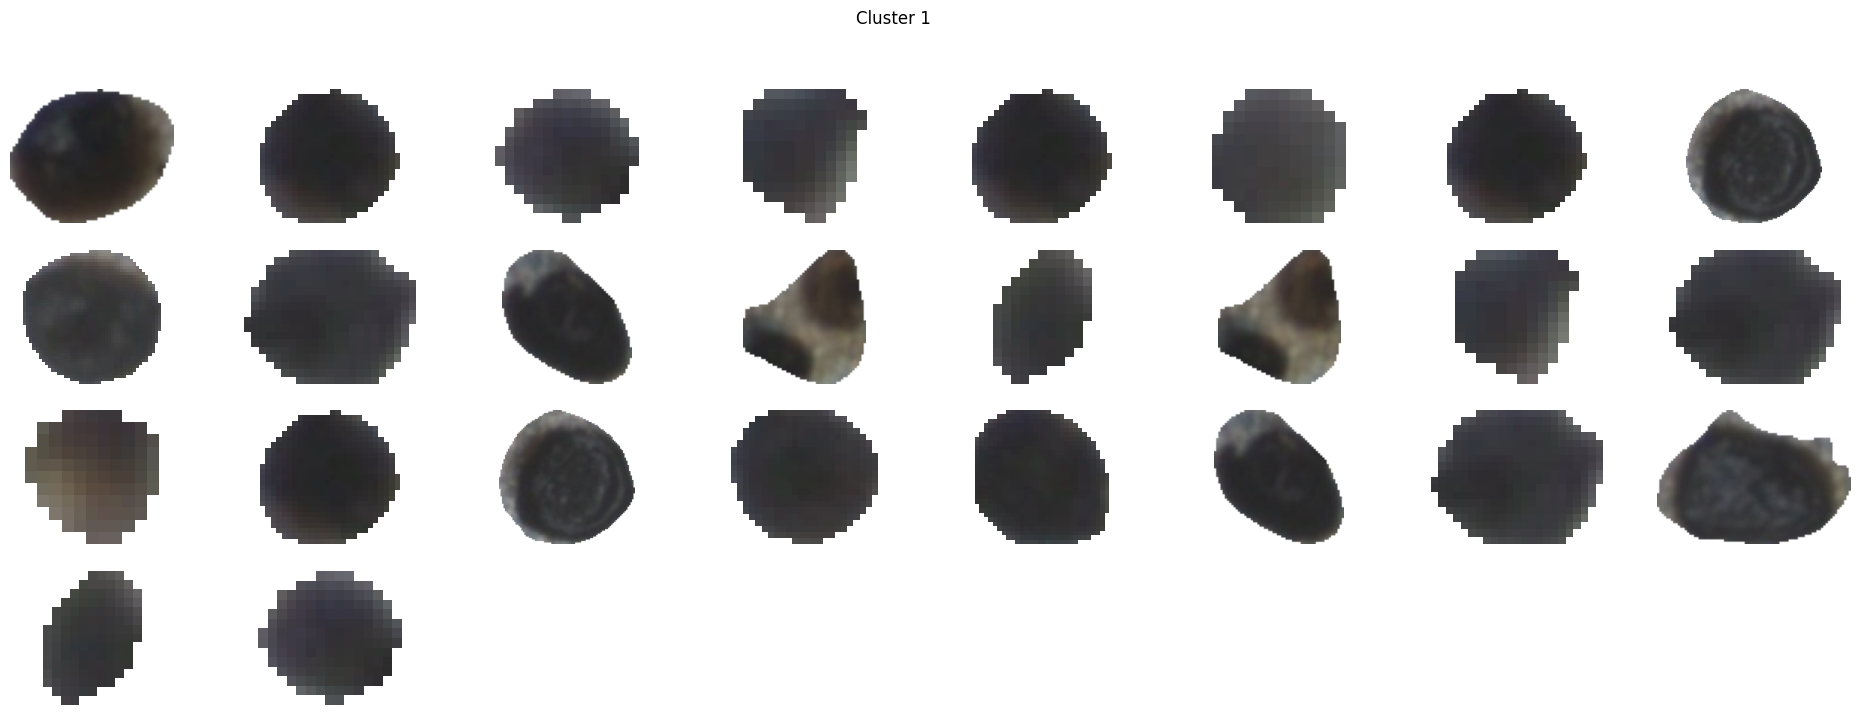

In [38]:
# primary clustering --> (update with initial stage features) --> reorder arg order such that first cluster is always dro and second is always corr  
counts_i, prob_args_i, frame_IDs_ = primary_clustering(pc_df=pc_df,
                                       frame_IDs=[frame_IDs_all[-1]],
                                       num_clusters=2,
                                       clustering_method='kmeans++',
                                       scaling_method='minmax',
                                       roi_key='inner',
                                       show_center=True,
                                       trace_back=True,
                                       image_dir_=image_dir_,
                                       pos_ref_ID=pos_ref_ID,
                                       bri_ref_ID=bri_ref_ID,
                                       mask_dict=mask_coords_inner,
                                       num_segs=100
                                       )

In [39]:
## VERY IMPORTANT! DETERMINED BY CHECKING TRACE BACK RESULT.
dro_idx_list_i = [0]
corr_idx_list_i = [1]

In [40]:
update_dro_center_with_early_data = True

(348,)
[KMeans(n_clusters=2, random_state=42), 'kmeans++', array([[0.75987142, 0.41802494, 0.29337469, 0.46736523],
       [0.17728547, 0.40597763, 0.46589356, 0.54856981]]), MinMaxScaler(), 'minmax']


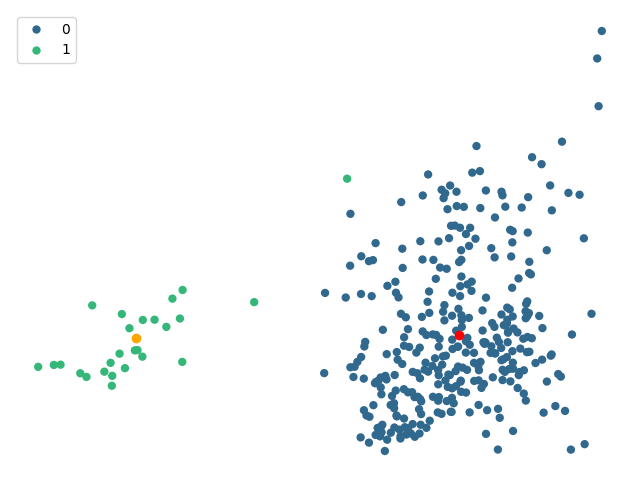

In [41]:
# ------------ Optional -------------
if update_dro_center_with_early_data:
    counts_updated_i, prob_args_updated_i = update_clustering(pc_df=pc_df,
                                                          frame_IDs=frame_IDs_,
                                                          frame_IDs_update=[frame_IDs_all[0]],
                                                          dro_idx=dro_idx_list_i[0],
                                                          num_clusters=prob_args_i[0].n_clusters,
                                                          scaling_method=prob_args_i[-1],
                                                          clustering_method=prob_args_i[1],
                                                          roi_key='inner',
                                                          show_center=True)
    prob_args_passed_i = prob_args_updated_i
    counts_passed_i = counts_updated_i
else:
    prob_args_passed_i = prob_args_i
    counts_passed_i = counts_i

In [42]:
prob_args_refined_i = refine_centers(prob_args=prob_args_passed_i,
                                   counts=counts_passed_i,
                                   dro_idx_list=dro_idx_list_i,
                                   corr_idx_list=corr_idx_list_i)

[KMeans(n_clusters=2, random_state=42), 'kmeans++', [array([0.75987142, 0.41802494, 0.29337469, 0.46736523]), array([0.17728547, 0.40597763, 0.46589356, 0.54856981])], MinMaxScaler(), 'minmax']


In [43]:
plt.close('all')

### Outer

(174,)
[KMeans(n_clusters=2, random_state=42), 'kmeans++', array([[0.60562649, 0.60312583, 0.76973663, 0.20759668, 0.22179114,
        0.43147257],
       [0.21757359, 0.59901312, 0.80424083, 0.19547532, 0.23947821,
        0.50417325]]), MinMaxScaler(), 'minmax']


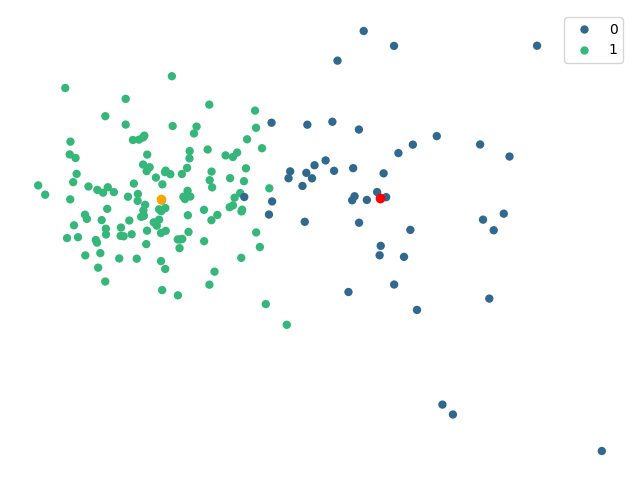

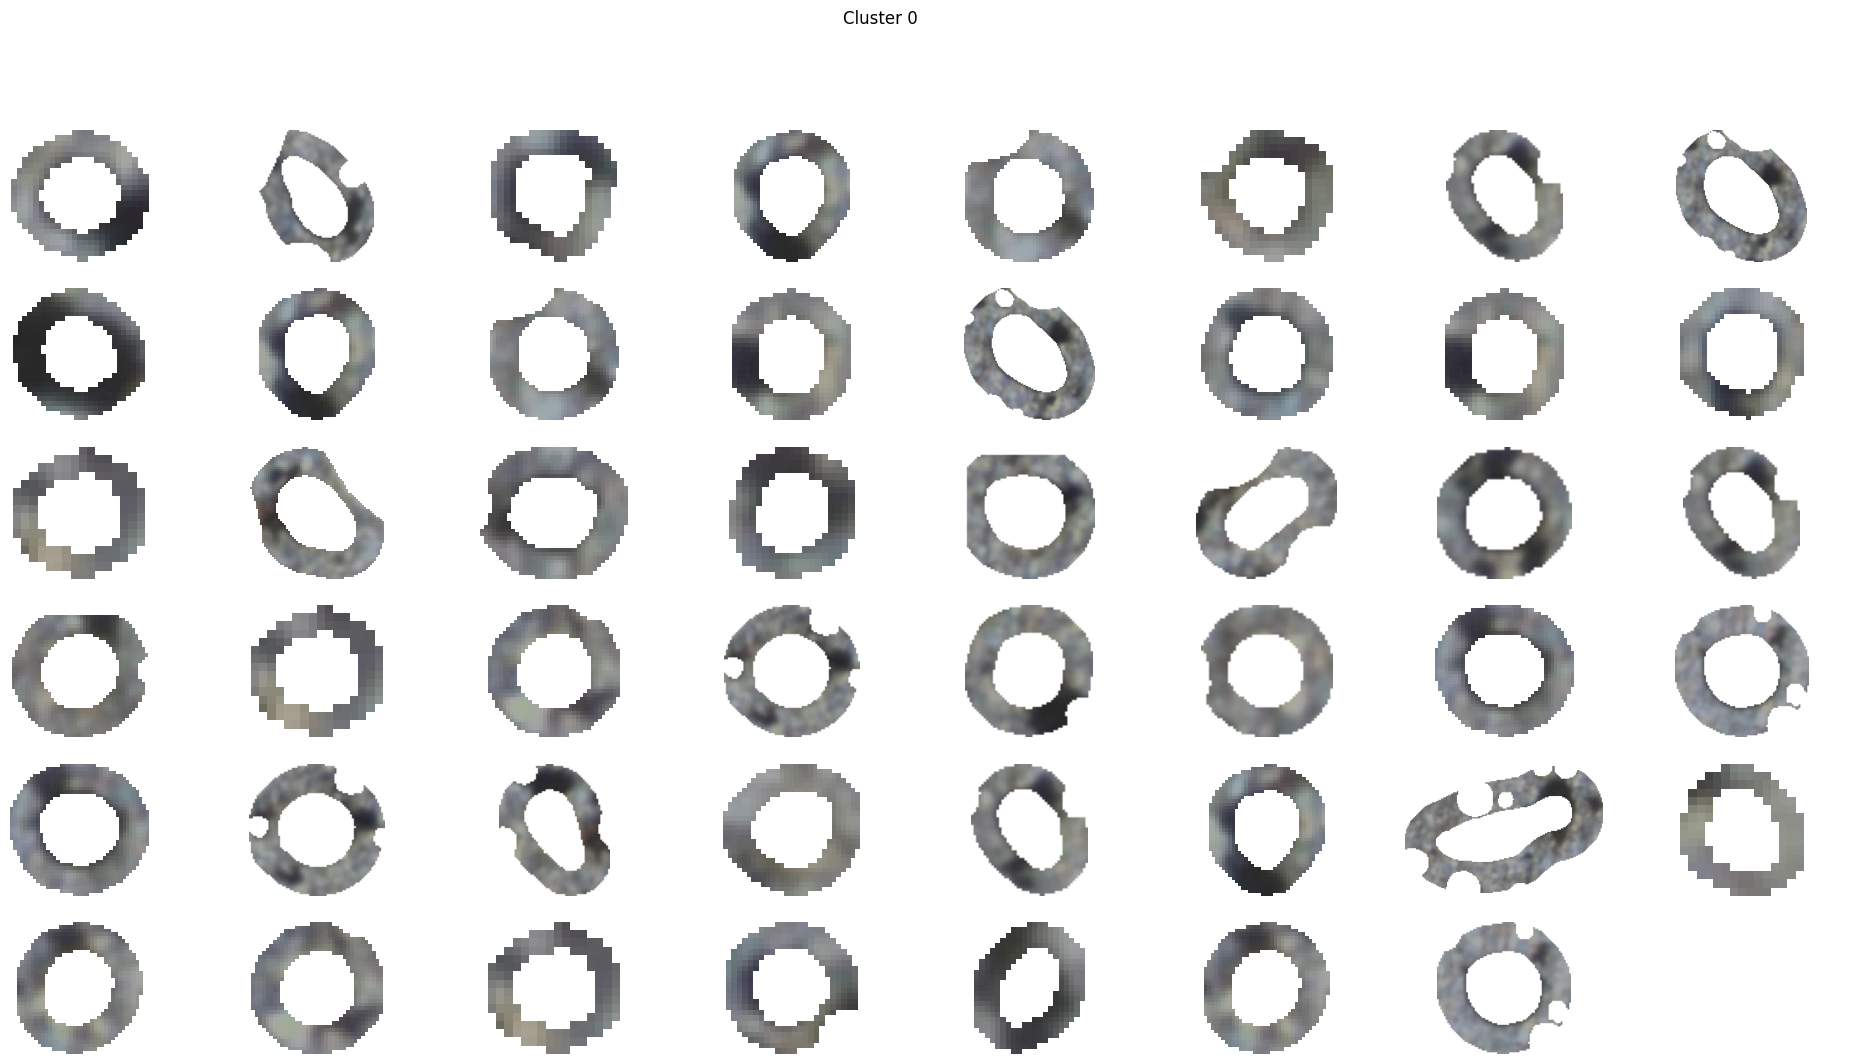

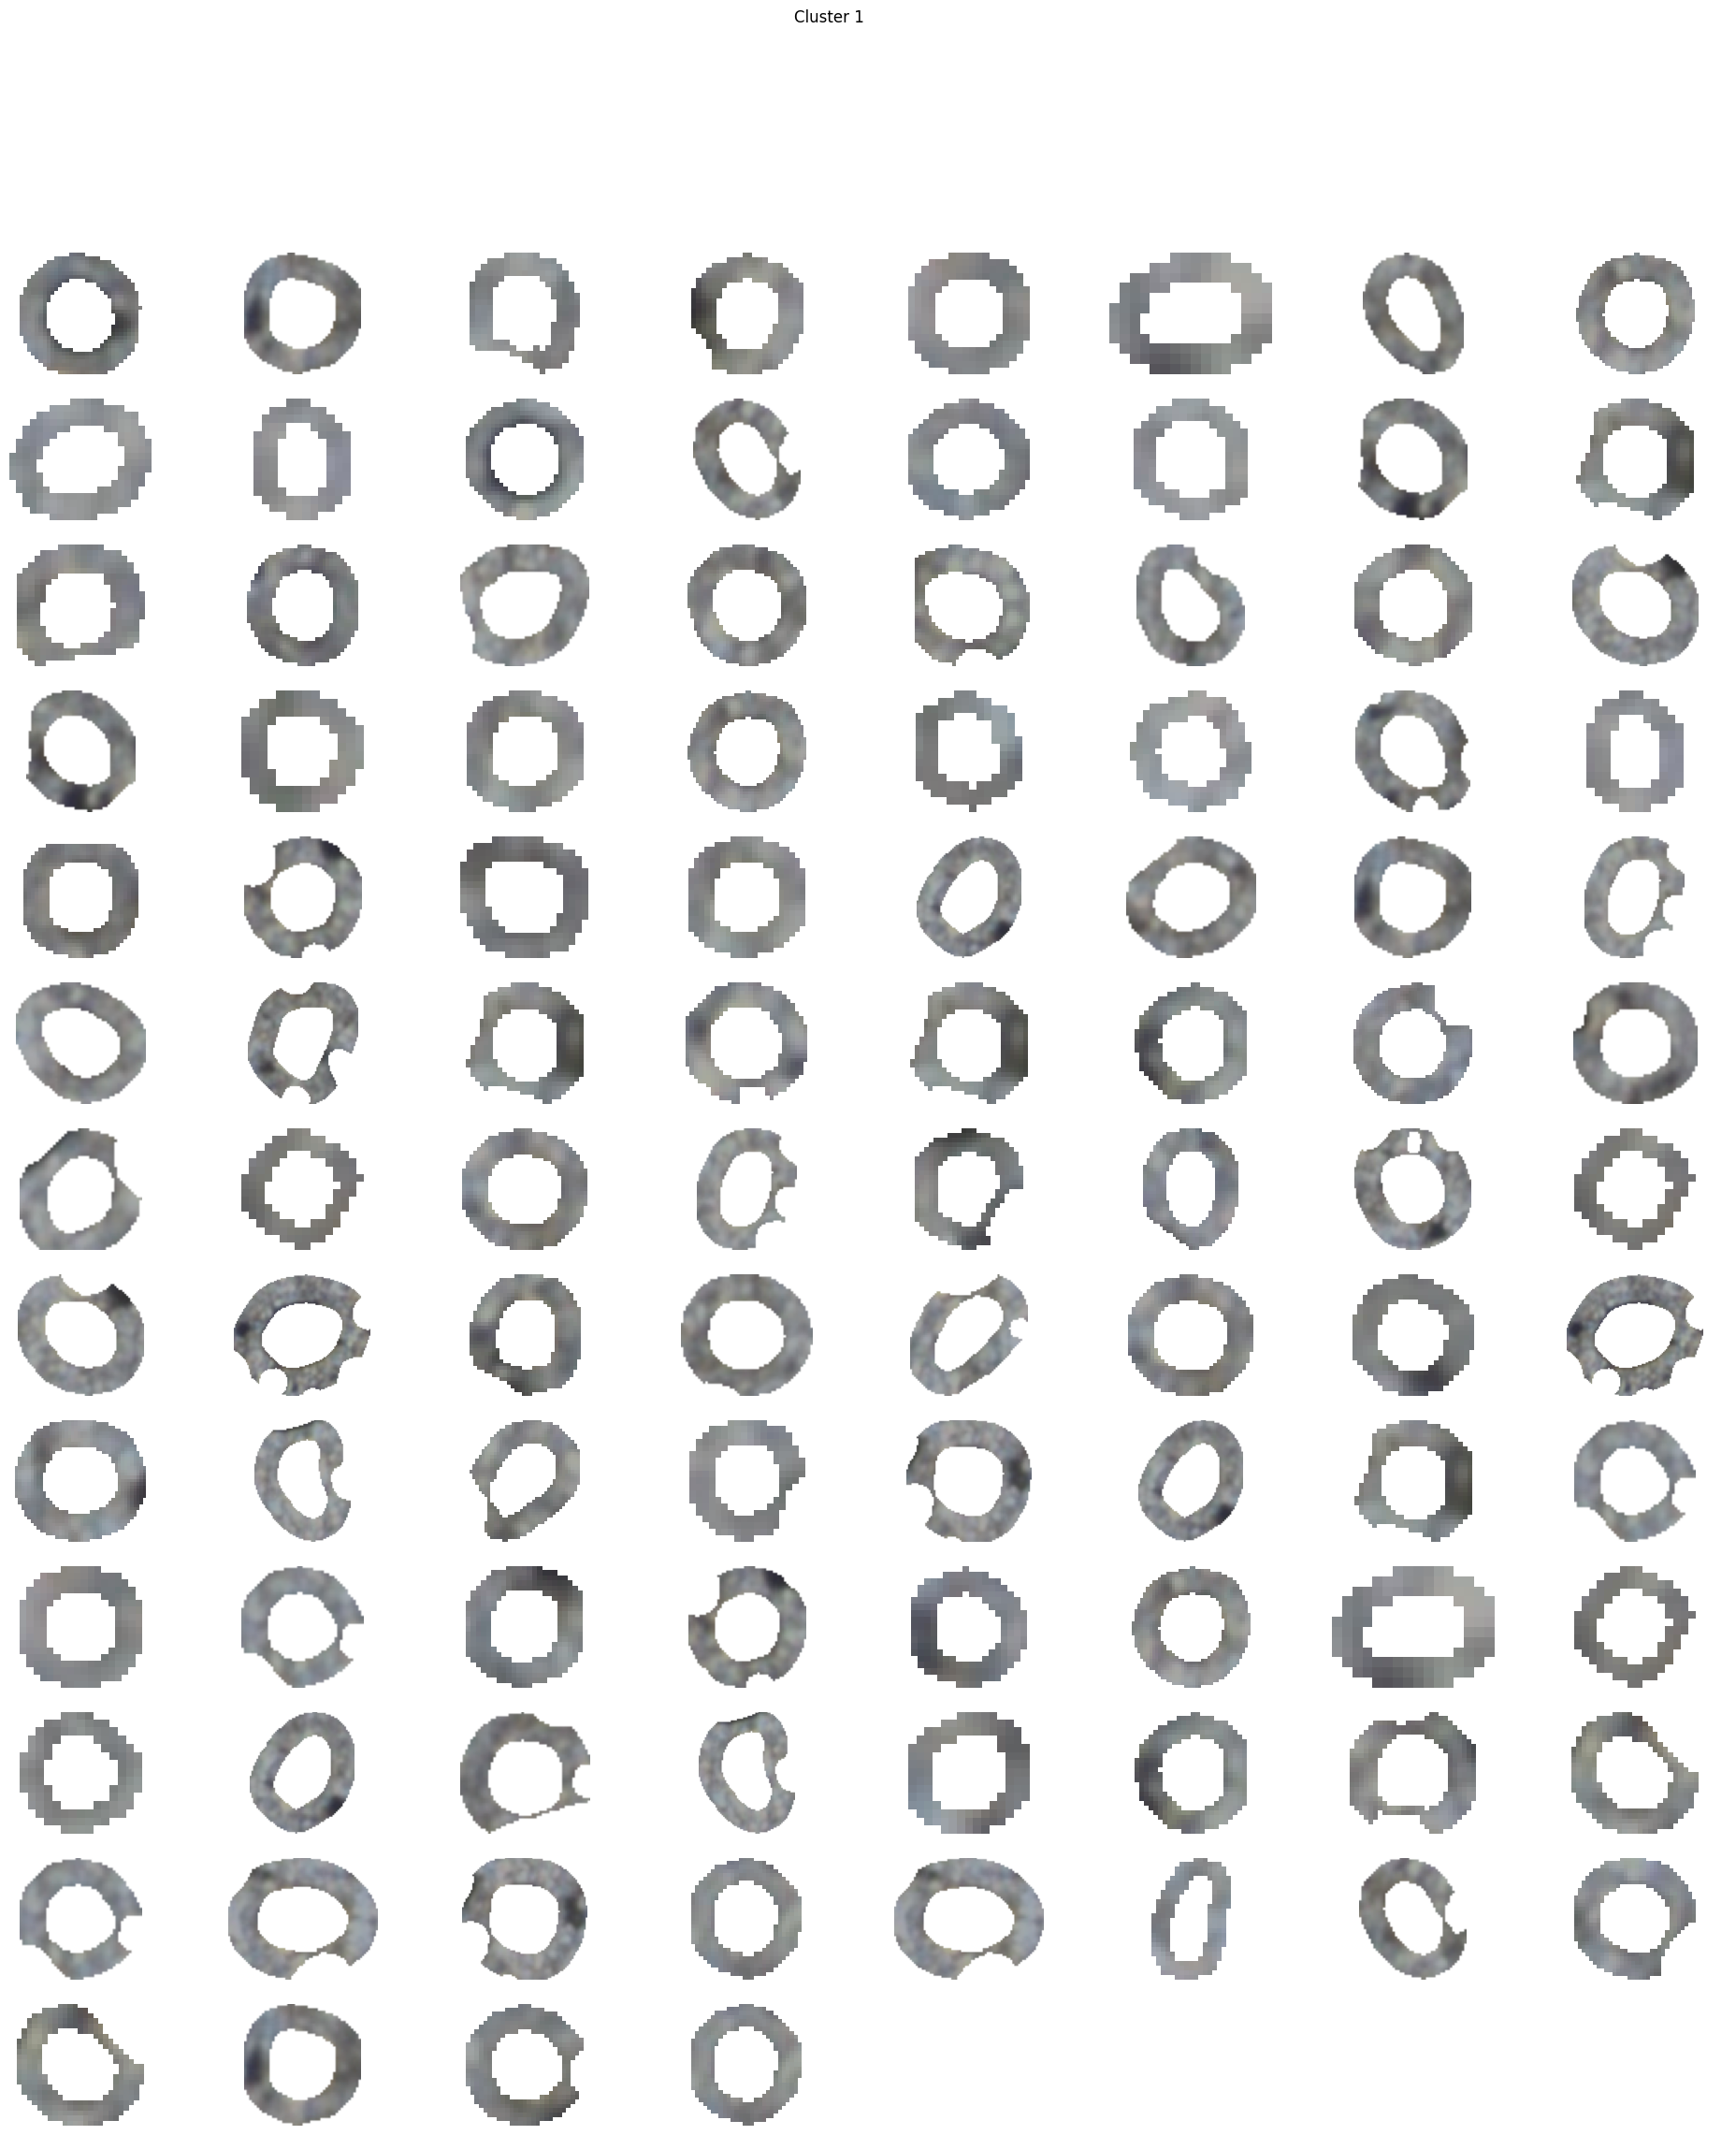

In [44]:
counts_o, prob_args_o, _ = primary_clustering(pc_df=pc_df,
                                       frame_IDs=frame_IDs_,
                                       num_clusters=2,
                                       clustering_method='kmeans++',
                                       scaling_method='minmax',
                                       roi_key='outer',
                                       show_center=True,
                                       trace_back=True,
                                       image_dir_=image_dir_,
                                       pos_ref_ID=pos_ref_ID,
                                       bri_ref_ID=bri_ref_ID,
                                       mask_dict=mask_coords_outer,
                                       num_segs=100
                                       )

In [45]:
## VERY IMPORTANT! DETERMINED BY CHECKING TRACE BACK RESULT.
dro_idx_list_o = [1]
corr_idx_list_o = [0]

(348,)
[KMeans(n_clusters=2, random_state=42), 'kmeans++', array([[0.60562649, 0.60312583, 0.76973663, 0.20759668, 0.22179114,
        0.43147257],
       [0.21048099, 0.59241995, 0.79523632, 0.20161608, 0.22978515,
        0.72571959]]), MinMaxScaler(), 'minmax']


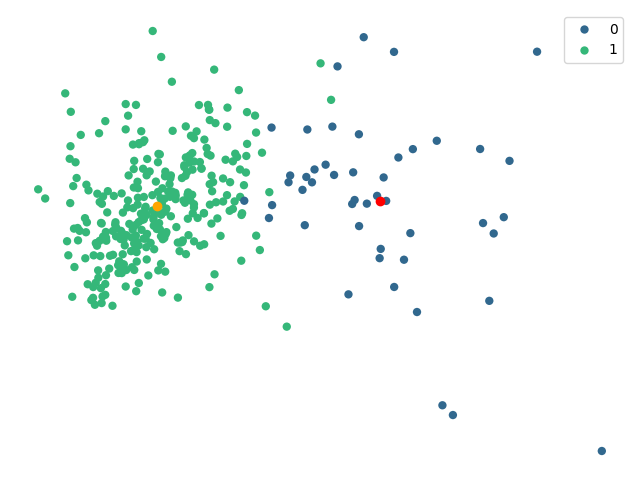

In [46]:
# ------------ Optional -------------
if update_dro_center_with_early_data:
    counts_updated_o, prob_args_updated_o = update_clustering(pc_df=pc_df,
                                                          frame_IDs=frame_IDs_,
                                                          frame_IDs_update=[frame_IDs_all[0]],
                                                          dro_idx=dro_idx_list_o[0],
                                                          num_clusters=prob_args_o[0].n_clusters,
                                                          scaling_method=prob_args_o[-1],
                                                          clustering_method=prob_args_o[1],
                                                          roi_key='outer',
                                                          show_center=True)
    prob_args_passed_o = prob_args_updated_o
    counts_passed_o = counts_updated_o
else:
    prob_args_passed_o = prob_args_o
    counts_passed_o = counts_o

In [47]:
prob_args_refined_o = refine_centers(prob_args=prob_args_updated_o,
                                   counts=counts_updated_o,
                                   dro_idx_list=dro_idx_list_o,
                                   corr_idx_list=corr_idx_list_o)

[KMeans(n_clusters=2, random_state=42), 'kmeans++', [array([0.21048099, 0.59241995, 0.79523632, 0.20161608, 0.22978515,
       0.72571959]), array([0.60562649, 0.60312583, 0.76973663, 0.20759668, 0.22179114,
       0.43147257])], MinMaxScaler(), 'minmax']


In [48]:
plt.close('all')

## Construct df for all

In [49]:
from droplet_corr_lab.compute import construct_p_all_frames

In [50]:
construct_p_all_frames(pc_df=pc_df,
                       region='inner_outer',
                       prob_args_inner=prob_args_refined_i,
                       prob_args_outer=prob_args_refined_o,
                       norm_w_inner=norm_w_inner,
                       norm_w_outer=norm_w_outer,
                       distance_method='softmax',
                       if_save=True,
                       raw_features_dir=r_dir,
                       roi_frac=roi_outer_frac)

## Analysis

In [51]:
from droplet_corr_lab.analysis import Analysis, Visualization

In [52]:
file_obj = Analysis(
     mask_ID=mask_ID,
     w_sg=5,
     poly=2,
     slope_threshold=0.005,
     min_length=3,
     min_value=0.5,
     search_start=None,
     T=20.0
)

In [53]:
file_obj.load_file(
     file_path=f"../data/demo/pc_df_roi_{roi_outer_frac}/inner_{num_pc_inner}_outer_{num_pc_outer}_pro_included.csv"
)
file_obj.compute_xy_dict(
    mode='plat',
    p_thresh=0.5,
    if_clustered=False
)

Thresh used: 4.9126202239975


In [54]:
vis_obj = Visualization(
     p_df=file_obj.p_df,
     xy_dict=file_obj.xy_dict,
     status_dict_inner=file_obj.status_dict_inner,
     status_dict_outer=file_obj.status_dict_outer,
     mask_ID=mask_ID,
     pos_ref_rgb=pos_ref_rgb,
     bri_ref_rgb=bri_ref_rgb,
     T=file_obj.T
)

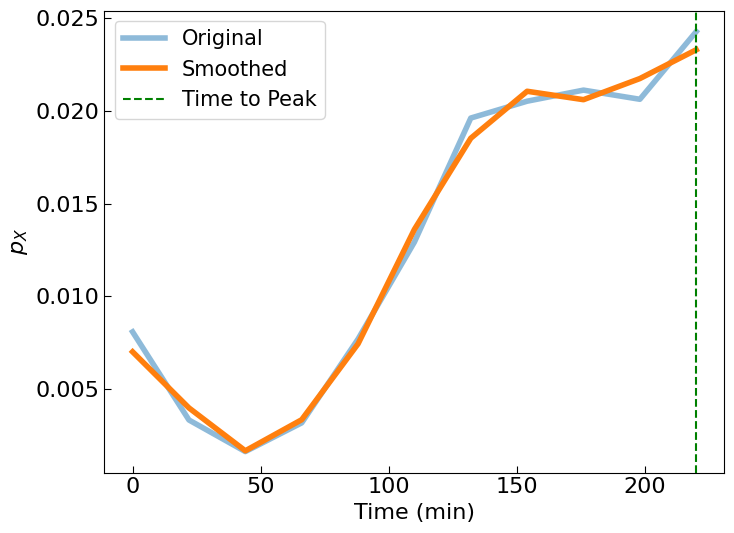

In [55]:
vis_obj.plot_curve_statistics(file_obj.p_df['bbox'].unique()[60], 'inner')